# Bayesian linear regression

In [1]:
%load_ext watermark
%watermark -v -m -p matplotlib,numpy,sklearn

CPython 3.7.4
IPython 7.8.0

matplotlib 3.1.1
numpy 1.17.2
sklearn 0.21.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


In [19]:
import matplotlib

matplotlib.rcParams.update({'font.size': 11})

In [2]:
%config InlineBackend.figure_format = 'retina'

## Textbook implementation

In [3]:
import numpy as np
from scipy import stats

class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean
        
        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
    
    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=model.mean, cov=cov)

## Progressive validation

Let's run this on the Boston dataset.

In [126]:
from sklearn import datasets
from sklearn import metrics

X, y = datasets.load_boston(return_X_y=True)

model = BayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.learn(xi, yi)

print(metrics.mean_absolute_error(y, y_pred))

3.784125061866257
CPU times: user 390 ms, sys: 3.56 ms, total: 393 ms
Wall time: 393 ms


Okay. As a reference point we'll run a linear regression trained with SGD.

In [82]:
from sklearn import exceptions
from sklearn import linear_model
from sklearn import preprocessing

model = linear_model.SGDRegressor(eta0=0.15)  # here eta0 is the learning rate

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(preprocessing.scale(X), y)):
    try:
        y_pred[i] = model.predict([xi])[0]
    except exceptions.NotFittedError:
        y_pred[i] = 0.
    model.partial_fit([xi], [yi])
    
print(metrics.mean_absolute_error(y, y_pred))

4.171800265184048


Naturally we could tinker with the parameters, but it seems that Bayesian linear regression is doing okay.

## Some visualisation

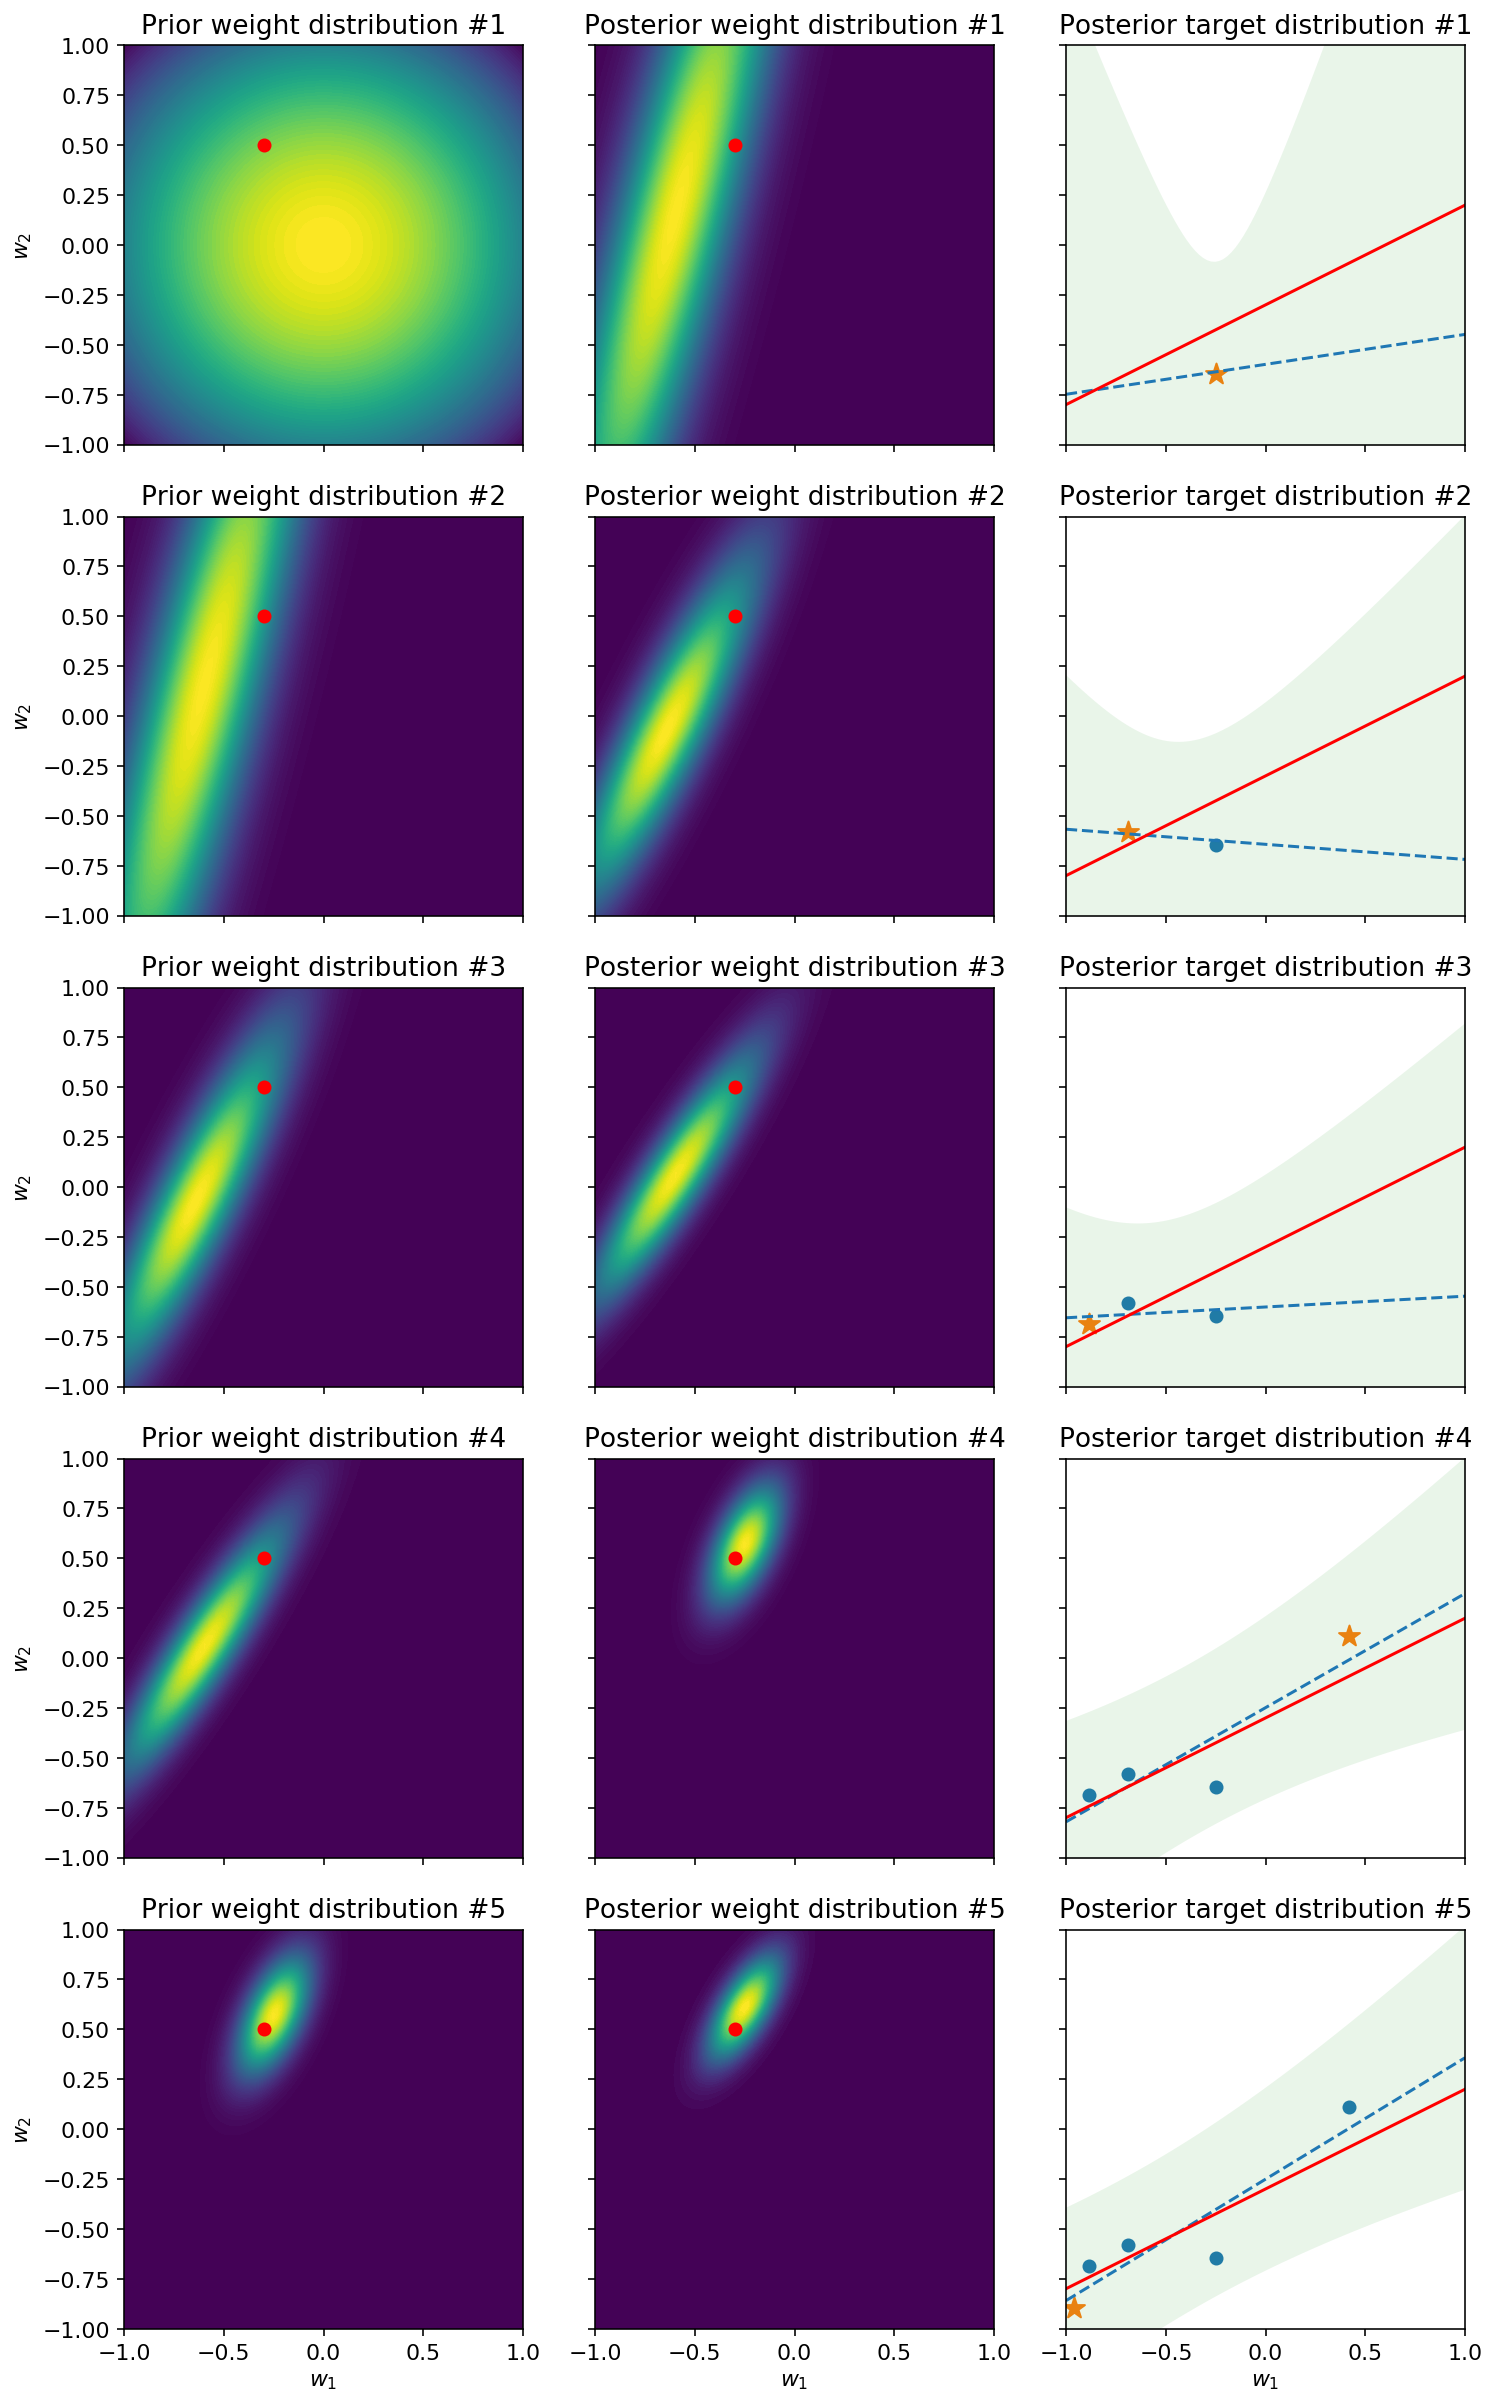

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

np.random.seed(42)

# Pick some true parameters which the model has to find
weights = np.array([-.3, .5])

def sample(n):
    
    for _ in range(n):
        x = np.array([1, np.random.uniform(-1, 1)])
        y = np.dot(weights, x) + np.random.normal(0, .2)
        yield x, y
        
model = BayesLinReg(n_features=2, alpha=2, beta=25)

N = 100
w = np.linspace(-1, 1, 100)
W = np.dstack(np.meshgrid(w, w))

n_samples = 5
fig = plt.figure(figsize=(7 * n_samples, 21))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(n_samples, 3),  # creates a n_samplesx3 grid of axes
    axes_pad=.5  # pad between axes in inch.
)

# We'll store the features and targets for plotting purposes
xs = []
ys = []

def prettify_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

for i, (xi, yi) in enumerate(sample(n_samples)):
    
    pred_dist = model.predict(xi)
    
    # Prior weight distribution
    ax = prettify_ax(grid[3 * i])
    ax.set_title(f'Prior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find
    
    # Update model
    model.learn(xi, yi)
    
    # Prior weight distribution
    ax = prettify_ax(grid[3 * i + 1])
    ax.set_title(f'Posterior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N, cmap='viridis')
    ax.scatter(*weights, color='red')  # true weights the model has to find
    
    # Posterior target distribution
    xs.append(xi)
    ys.append(yi)
    posteriors = [model.predict(np.array([1, wi])) for wi in w]
    ax = prettify_ax(grid[3 * i + 2])
    ax.set_title(f'Posterior target distribution #{i + 1}')
    # Plot the old points and the new point
    ax.scatter([xi[1] for xi in xs[:-1]], ys[:-1])
    ax.scatter(xs[-1][1], ys[-1], marker='*', s=120)
    # Plot the predictive mean along with the predictive interval
    ax.plot(w, [p.mean() for p in posteriors], linestyle='--')
    cis = [p.interval(0.95) for p in posteriors]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=.1
    )
    # Plot the true target distribution
    ax.plot(w, [np.dot(weights, [1, xi]) for xi in w], color='red')
    
fig.savefig('viz.png', dpi=200, bbox_inches='tight')

## Prediction interval

Gaussian data.

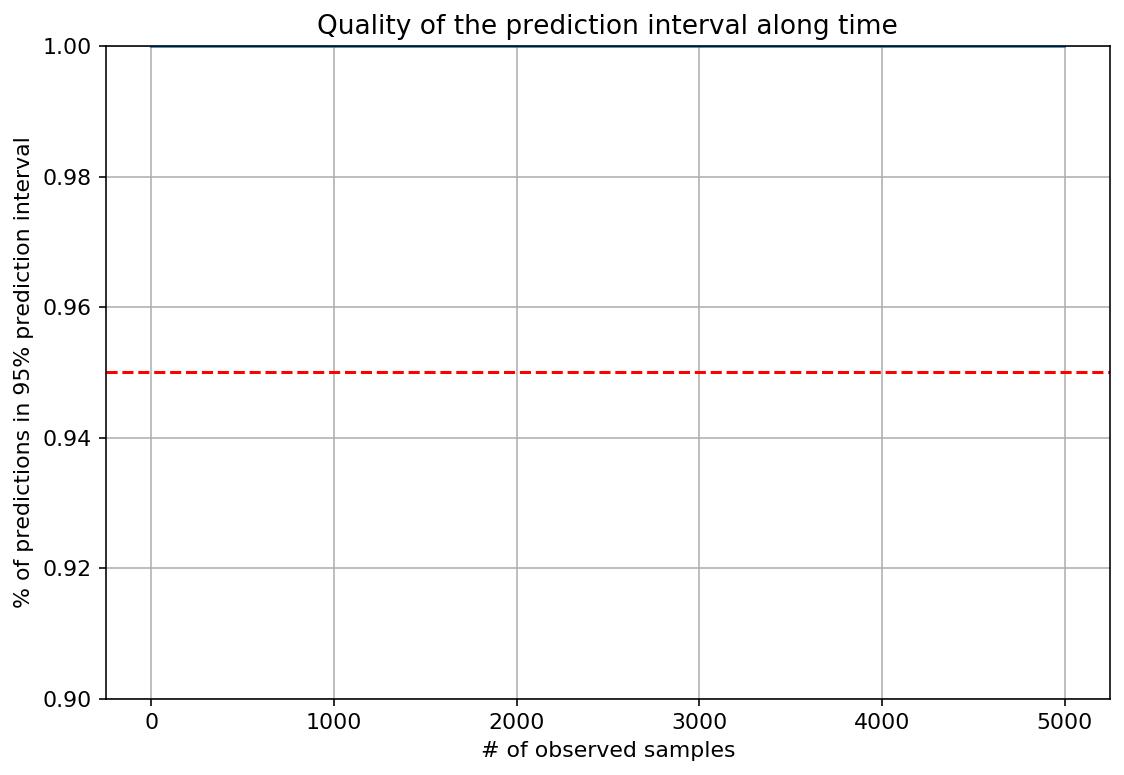

In [91]:
np.random.seed(42)
        
model = BayesLinReg(n_features=2, alpha=1, beta=25)
pct_in_ci = 0
pct_in_ci_hist = []
n = 5_000

for i, (xi, yi) in enumerate(sample(n)):
    
    ci = model.predict(xi).interval(.95)
    in_ci = ci[0] < yi < ci[1]
    pct_in_ci += (in_ci - pct_in_ci) / (i + 1)  # online update of an average
    pct_in_ci_hist.append(pct_in_ci)
    
    model.learn(xi, yi)
    
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(n), pct_in_ci_hist)
ax.axhline(y=.95, color='red', linestyle='--')
ax.set_title('Quality of the prediction interval along time')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('% of predictions in 95% prediction interval')
ax.set_ylim(.9, 1)
ax.grid()

#fig.savefig('ci.png', dpi=200)

California housing.

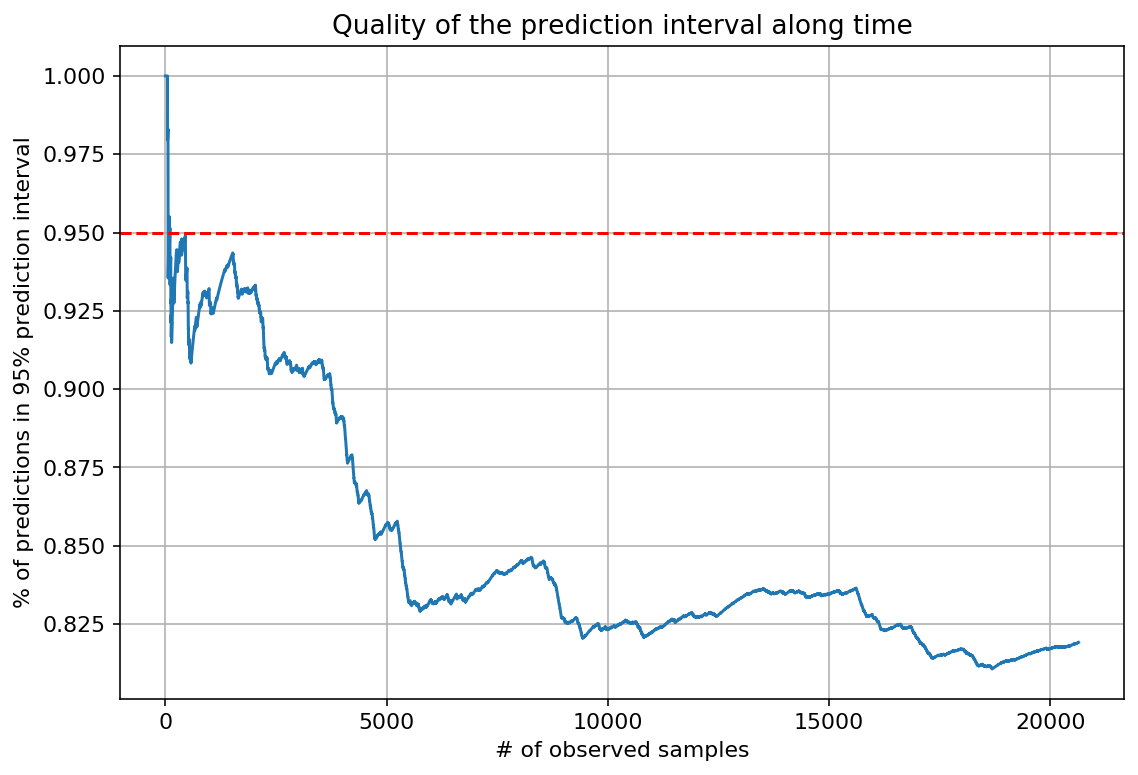

In [49]:
X, y = datasets.fetch_california_housing(return_X_y=True)

model = BayesLinReg(n_features=X.shape[1], alpha=1, beta=5)
pct_in_ci = 0
pct_in_ci_hist = []

for i, (xi, yi) in enumerate(zip(X, y)):
    
    ci = model.predict(xi).interval(.95)
    in_ci = ci[0] < yi < ci[1]
    pct_in_ci += (in_ci - pct_in_ci) / (i + 1)  # online update of an average
    pct_in_ci_hist.append(pct_in_ci)
    
    model.learn(xi, yi)
    
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(len(X)), pct_in_ci_hist)
ax.axhline(y=.95, color='red', linestyle='--')
ax.set_title('Quality of the prediction interval along time')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('% of predictions in 95% prediction interval')
#ax.set_ylim(.9, 1)
ax.grid()

fig.savefig('ci_california.png', dpi=200)

## Mini-batching

Let's implement a version that can take as input multiple samples as well as a single one. The code is mostly the same; there's just some `numpy` wizardry to figure out. Here I'm inheriting from `BayesLinReg` simply in order to avoir reimplementing the `__init__` function.

In [56]:
class BatchBayesLinReg(BayesLinReg):

    def learn(self, x, y):
        
        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * x.T @ x

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y @ x)

        self.cov_inv = cov_inv
        self.mean = mean
        
        return self

    def predict(self, x):
        
        x = np.atleast_2d(x)

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + (x @ w_cov * x).sum(axis=1)
        
        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

Let's split the dataset in two so that we compare the online approach against the batch approach.

In [54]:
from sklearn import model_selection

X, y = datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, shuffle=True, random_state=42)

Online.

In [53]:
%%time

model = BayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

for x, y in zip(X_train, y_train):
    model.learn(x, y)
    
y_pred = np.empty(len(X_test))

for i, (x, _) in enumerate(zip(X_test, y_test)):
    y_pred[i] = model.predict(x).mean()
    
metrics.mean_absolute_error(y_test, y_pred)

CPU times: user 4.78 s, sys: 46.9 ms, total: 4.82 s
Wall time: 4.82 s


0.5700931805968609

Batch.

In [57]:
%%time

model = BatchBayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

model.learn(X_train, y_train)
y_pred = model.predict(X_test).mean()
    
metrics.mean_absolute_error(y_test, y_pred)

CPU times: user 25.5 ms, sys: 3.4 ms, total: 28.9 ms
Wall time: 6.42 ms


0.5700931805975361

Linear regression.

In [60]:
%%time

model = linear_model.LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
metrics.mean_absolute_error(y_test, y_pred)

CPU times: user 8.47 ms, sys: 1.17 ms, total: 9.64 ms
Wall time: 3.24 ms


0.5272474538306154

The batch approach is significantly. The downside is that all the data has to be available at once. We can do something in between and use mini-batches. 

In [62]:
%%time

model = BatchBayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

batch_size = 16
n_batches = len(X_train) // batch_size

for x_batch, y_batch in zip(np.array_split(X_train, n_batches), np.array_split(y_train, n_batches)):
    model.learn(x_batch, y_batch)
    
y_pred = model.predict(X_test).mean()
    
metrics.mean_absolute_error(y_test, y_pred)

CPU times: user 47.4 ms, sys: 1.88 ms, total: 49.3 ms
Wall time: 36.9 ms


0.5700931805978622

## Handling concept drift

How well does our model fair against concept drift? We can simulate a drift by picking two sets of parameters and transitioning between both sets. If the model is robust, then the errors along time should remain somewhat the same, with some kinks when transitions occur.

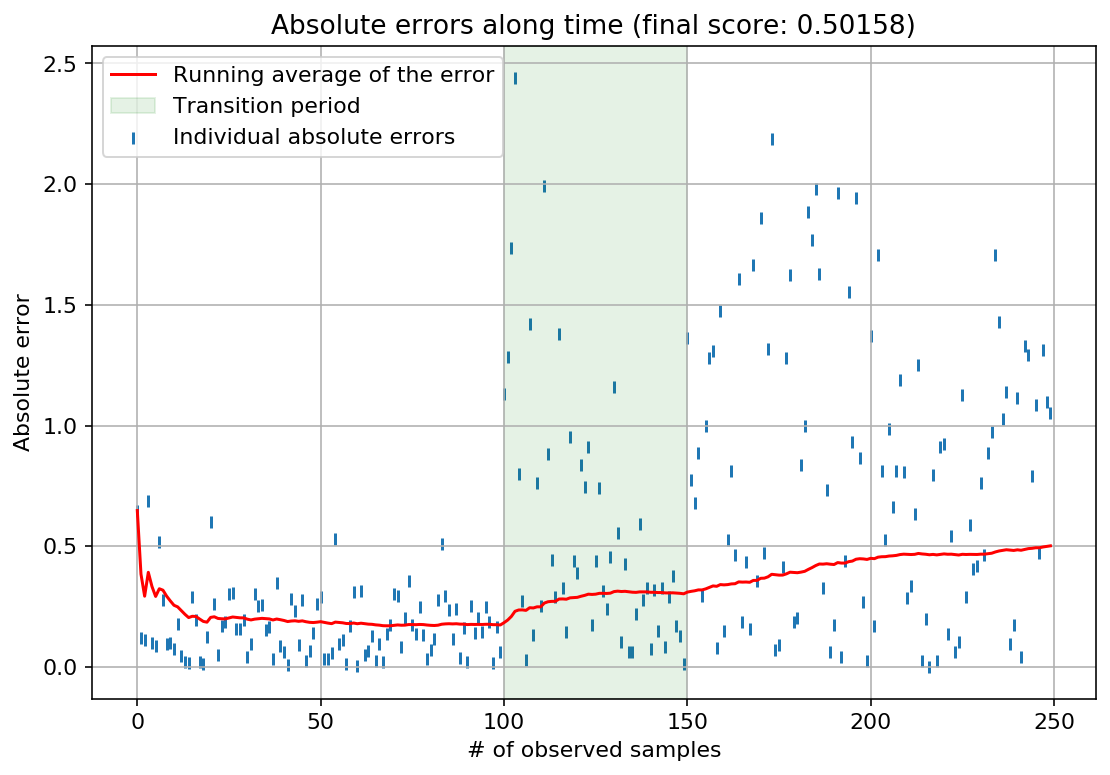

In [63]:
def sample(first_period=100, transition_period=50, second_period=100):
    
    start_weights = np.array([-.3, .5])
    end_weights = np.array([1, -.7])
    
    for i in range(first_period + transition_period + second_period):
        
        x = np.array([1, np.random.uniform(-1, 1)])
        
        if i < first_period:
            weights = start_weights
            
        elif i < first_period + transition_period:
            alpha = (i - first_period) / transition_period
            weights = alpha * start_weights + (1 - alpha) * end_weights
            
        else:
            weights = end_weights
            
        yield x, np.dot(weights, x) + np.random.normal(0, .2)
     
np.random.seed(42)
    
model = BayesLinReg(n_features=2, alpha=2, beta=25)

y_true = []
y_pred = []

first_period = 100
transition_period = 50
second_period = 100

for i, (xi, yi) in enumerate(sample(first_period, transition_period, second_period)):
    y_true.append(yi)
    y_pred.append(model.predict(xi).mean())
    model.learn(xi, yi)
    
# Convert to numpy arrays for comfort
y_true = np.array(y_true)
y_pred = np.array(y_pred)

score = metrics.mean_absolute_error(y_true, y_pred)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(range(len(y_true)), np.abs(y_true - y_pred), marker='|', label='Individual absolute errors')
ax.plot(np.cumsum(np.abs(y_true - y_pred)) / (np.arange(len(y_true)) + 1), color='red', label='Running average of the error')
ax.set_title(f'Absolute errors along time (final score: {score:.5f})')
ax.axvspan(first_period, first_period + transition_period, alpha=.1, color='green', label='Transition period')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('Absolute error')
ax.legend()
ax.grid()

fig.savefig('drift_vanilla.png', dpi=200)

Clearly the model isn't coping very well with drift. Can we do something about it? I've never seen this answered in textbooks. The only place I found something about it was in [Vincent Warmerdam's blog post](https://koaning.io/posts/bayesian-propto-streaming/), in the *Extra Modelling Options* section. He hints at using a smoothing term to essentially give more importance to recent observations. As he says, this feels a bit like a hack because there doesn't to be much theoretical justification backing this "trick". I implemented Vincent's idea and it seems to work very well.

In [65]:
import numpy as np

class RobustBayesLinReg(BayesLinReg):

    def __init__(self, smoothing, n_features, alpha, beta):
        super().__init__(n_features, alpha, beta)
        self.smoothing = smoothing

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.smoothing * self.cov_inv + (1 - self.smoothing) * self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.smoothing * self.cov_inv @ self.mean + (1 - self.smoothing) * self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean
        
        return self

Here's the online validation. We'll use the same random seed in order to compare with the previous experiment. 

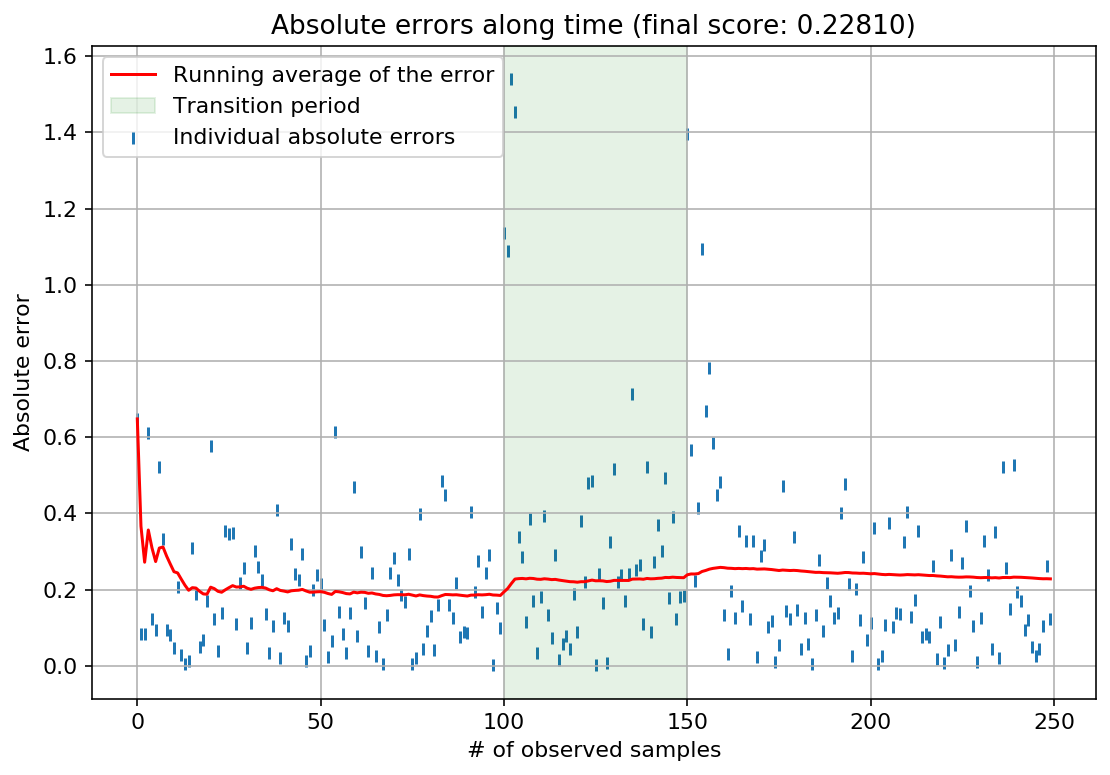

In [66]:
np.random.seed(42)

model = RobustBayesLinReg(smoothing=.8, n_features=2, alpha=2, beta=25)

y_true = []
y_pred = []

for i, (xi, yi) in enumerate(sample(first_period, transition_period, second_period)):
    y_true.append(yi)
    y_pred.append(model.predict(xi).mean())
    model.learn(xi, yi)
    
# Convert to numpy arrays for comfort
y_true = np.array(y_true)
y_pred = np.array(y_pred)

score = metrics.mean_absolute_error(y_true, y_pred)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(range(len(y_true)), np.abs(y_true - y_pred), marker='|', label='Individual absolute errors')
ax.plot(np.cumsum(np.abs(y_true - y_pred)) / (np.arange(len(y_true)) + 1), color='red', label='Running average of the error')
ax.set_title(f'Absolute errors along time (final score: {score:.5f})')
ax.axvspan(first_period, first_period + transition_period, alpha=.1, color='green', label='Transition period')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('Absolute error')
ax.legend()
ax.grid()

fig.savefig('drift_robust.png', dpi=200)

This works much better than the initial implementation! We can see that the errors spike at the beginning and the end of the transition periods. The model then seems to adapt and the errors get lower.

## Zero mean isotropic Gaussian prior

In [146]:
def sherman_morrison(A_inv, u, v):
    num = A_inv @ np.outer(u, v) @ A_inv
    den = 1 + v @ A_inv @ u
    return A_inv - num / den


class SimpleBayesLinReg:
    
    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.A_inv = np.linalg.inv(alpha * np.identity(n_features))
        self.cov = self.A_inv

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.54)
        self.cov = sherman_morrison(A_inv=self.A_inv, u=self.beta * x, v=x)

        # Update the mean vector (Bishop eq. 3.53)
        self.mean = self.beta * self.cov @ x * y
        
        return self
    
    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        y_pred_var = 1 / self.beta + x @ self.cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)    

In [145]:
X, y = datasets.load_boston(return_X_y=True)

model = SimpleBayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.learn(xi, yi)
    
print(metrics.mean_absolute_error(y, y_pred))

4.60968270902414
